## Comparing the baseline models with different word-embeddings

In [10]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,classification_report,confusion_matrix, precision_recall_fscore_support
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import fasttext
from txtclassifier_glove import *
from txtclassifier_bert import * 
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
org_df = pd.read_json("../data/News_Category_Dataset_v3.json", lines=True)
org_df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [13]:
# processed_df = preprocess(inputfile="../data/News_Category_Dataset_v3.json"\
#                           , labelfile="../data/label.json"\
#                           , decodelabelfile="../data/label_decode.json")

# Alternate way to use the saved pre-processed csv file.
processed_df = pd.read_csv("../data/processed_df.csv", header=0).drop('Unnamed: 0', axis=1)
processed_df

,category,text
0,WELLNESS,master of habit the wisdom and writing of maya...
1,WELLNESS,speak from the heart
2,SPORTS AND ENTERTAINMENT,george r r martin love marvel but not marvel m...
3,WELLNESS,be alcoholic anonymous negativitybased alcohol...
4,WELLNESS,watch tv can help you realize your eternal sel...
...,...,...
206238,SOCIAL,flacke with the father of birth control for co...
206239,SPORTS AND ENTERTAINMENT,grammar stickler parking ticket toss because o...
206240,TRAVEL,how to kill the tsas fullbody scanner for good...
206241,SPORTS AND ENTERTAINMENT,kate winslet in a little chaos kate winslet in...


In [17]:
X = processed_df['text']
y = processed_df['category']
classes = y.unique()
num_classes = len(y.unique())


df_train, df_val, df_test = data_split(processed_df)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(154682, 2)
(20624, 2)
(30937, 2)


#### Loading baseline model from the saved file

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, embedding_dict, num_classes, max_seq_len):
        super(TextCNN, self).__init__()
        embedding_dim = 100
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(np.random.normal(0, 1, (vocab_size, embedding_dim))))
        for word, idx in word_to_idx.items():
            if word in embedding_dict:
                self.embedding.weight.data[idx] = torch.from_numpy(embedding_dict[word])
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3)
        self.maxpool = nn.MaxPool1d(max_seq_len - 3 + 1)
        self.fc = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.maxpool(x)
        x = x.view(-1, 100)
        x = self.fc(x)
        return x

In [ ]:
def glove_evaluate_model(test_model, test_loader):
    
    # Set the model to evaluation mode
    test_model.eval()

    # Calculate the accuracy on the test set
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        predicted_labels = []
        for X_batch, y_batch in test_loader:
            y_pred = test_model(X_batch)
            y_pred = y_pred.argmax(dim=1)
            predicted_labels.extend(y_pred.tolist())

        true_labels = []
        for X_batch, y_batch in test_loader:
            true_labels.extend(y_batch.tolist())
                
        true_labels = [torch.argmax(torch.tensor(batch_labels)) for batch_labels in true_labels]
        true_labels = torch.tensor(true_labels, dtype=torch.int64)
        predicted_labels = torch.tensor(predicted_labels)

        class_counts = torch.bincount(true_labels)
        correct_counts = torch.bincount(true_labels[predicted_labels == true_labels], minlength=len(class_counts))

        accuracy = float(correct_counts.sum()) / float(class_counts.sum())
        precision = float(correct_counts[1]) / float(class_counts[1])
        recall = float(correct_counts[1]) / float(class_counts[1] + class_counts[0])
        f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score, predicted_labels, true_labels

In [ ]:
max_seq_len = 100
batch_size = 32
num_epochs = 1
learning_rate = 0.001
embedding_file_path = './data/glove/glove.6B.100d.txt'

print("Loading the glove word embeddings")
embedding_dict = load_embedding_dict(embedding_file_path)

print("Create word to index mappings")
word_to_idx, vocab_size = create_word_to_idx(X,embedding_dict)

print("Preprocess Data")
train_texts, train_labels, val_texts, val_labels, test_texts, test_labels = preprocess_data(processed_df, word_to_idx, max_seq_len=100)
    
print("Creating data loaders")
train_loader, val_loader, test_loader = create_data_loaders(train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, batch_size=32)

test_model = TextCNN(embedding_dict, num_classes = 15, max_seq_len = 100)

# Load the saved model state dict
state_dict = torch.load('../data/glove/glove_cnn_4.pth')

# Load the state dict into the model
test_model.load_state_dict(state_dict)

# Set the model to evaluation mode
test_model.eval()

accuracy, precision, recall, f1_score, predicted_labels, true_labels = glove_evaluate_model(test_model, test_loader)

print("Evaluation Results:\n"
      "Accuracy: {:.4f}\n"
      "Precision: {:.4f}\n"
      "Recall: {:.4f}\n"
      "F1 Score: {:.4f}\n".format(accuracy, precision, recall, f1_score))

Loading the glove word embeddings
Create word to index mappings
Preprocess Data
Creating data loaders
Evaluation Results:
Accuracy: 0.6756
Precision: 0.5743
Recall: 0.4479
F1 Score: 0.5033



In [ ]:
true_labels_name = [classes[label_index] for label_index in true_labels]
predicted_labels_name = [classes[label_index] for label_index in predicted_labels]

test_labels = true_labels_name
predicted_labels = predicted_labels_name

print(classification_report(test_labels, predicted_labels))

                          precision    recall  f1-score   support

        ARTS AND CULTURE       0.54      0.26      0.35       323
                 ECONOMY       0.75      0.81      0.78      2763
               EDUCATION       0.84      0.72      0.78       998
             ENVIRONMENT       0.77      0.70      0.73      3638
               LIFESTYLE       0.46      0.44      0.45      2084
                MARRIAGE       0.50      0.43      0.46       611
                MINORITY       0.75      0.78      0.76      5340
                  PARENT       0.49      0.58      0.53      2355
                POLITICS       0.72      0.65      0.68      1905
        SCIENCE AND TECH       0.65      0.68      0.66      1491
                  SOCIAL       0.56      0.40      0.47       610
SPORTS AND ENTERTAINMENT       0.52      0.57      0.55      1191
                  TRAVEL       0.79      0.76      0.78      2474
                WELLNESS       0.30      0.29      0.29       336
         

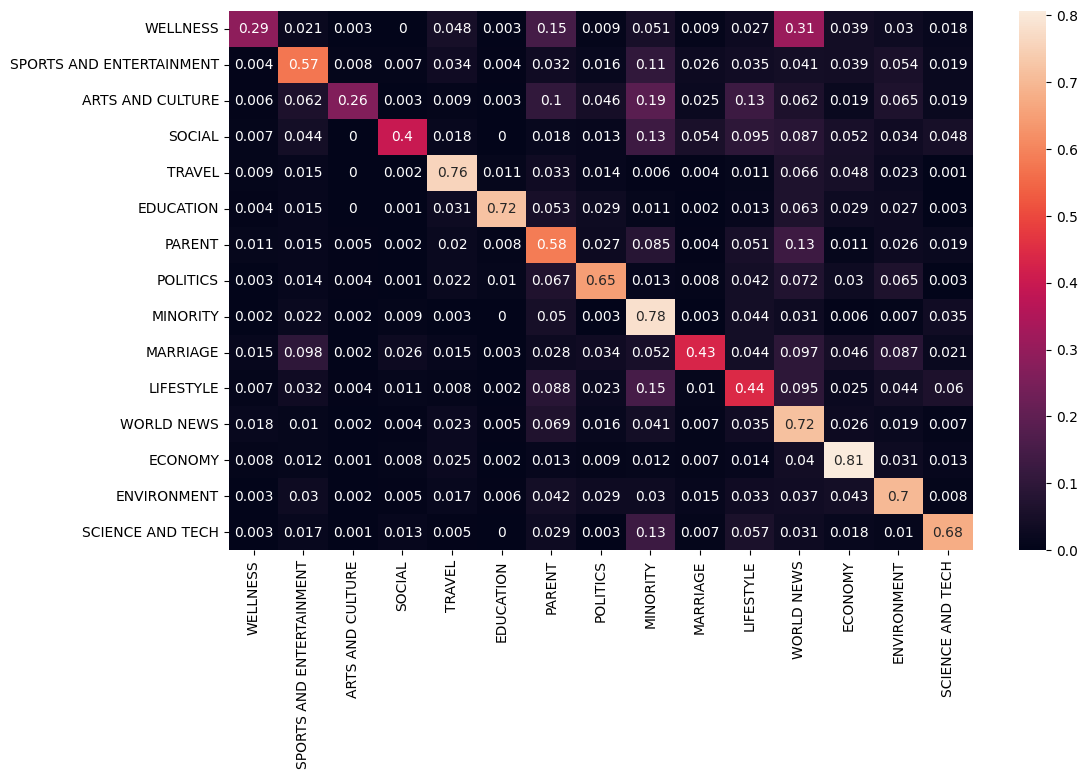

In [ ]:
cf_matrix = confusion_matrix(test_labels, predicted_labels, labels=classes)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], 
                     index = classes,
                     columns = classes).round(decimals=3)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig("confusion_matrix_hitmap_glove.png")

### Fast Text Model

In [ ]:
# Load pre-trained FastText embeddings
fasttext_model = fasttext.load_model('cc.en.300.bin')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def text_to_embedding(text, max_length):
  tokens = nltk.word_tokenize(text)
  tokens = tokens[:max_length] # Truncate to max_length
  embeddings = [fasttext_model.get_word_vector(token) for token in tokens]
  padding_length = max_length - len(embeddings)
  embeddings.extend([np.zeros(fasttext_model.get_dimension()) for _ in range(padding_length)])
  return np.array(embeddings)

In [ ]:
class FastTextCNN(nn.Module):
    def __init__(self, embedding_dim, num_filters, filter_sizes, num_classes, dropout_prob):
        super(FastTextCNN, self).__init__()

        self.convs1 = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])

        self.convs2 = nn.ModuleList([
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(fs, 1))
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout_prob)

        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension (batch_size, 1, max_length, embedding_dim)

        # Apply first set of convolutional layers with different filter sizes
        conv_outputs1 = []
        for conv1 in self.convs1:
            conv_output1 = torch.relu(conv1(x))
            conv_outputs1.append(conv_output1)

        # Apply second set of convolutional layers with different filter sizes
        conv_outputs2 = []
        for conv2, conv_output1 in zip(self.convs2, conv_outputs1):
            conv_output2 = torch.relu(conv2(conv_output1)).squeeze(3)
            pooled_output = torch.max_pool1d(conv_output2, conv_output2.size(2)).squeeze(2)
            conv_outputs2.append(pooled_output)

        x = torch.cat(conv_outputs2, 1)
        x = self.dropout(x)  # Dropout layer
        x = self.fc(x)  # Fully connected layer (batch_size, num_classes)
        return x

In [ ]:
def test(model, test_loader):
    model.eval()
    test_accuracy = 0
    with torch.no_grad():
        true_labels = []
        predicted_labels = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_predictions = torch.argmax(outputs, dim=1)
            test_accuracy += (test_predictions == labels).float().mean().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(test_predictions.cpu().numpy())

    test_accuracy /= len(test_loader)
    
    # Convert label indices to label names
    classes = le.inverse_transform(list(range(num_classes)))
    true_labels_name = [classes[label_index] for label_index in true_labels]
    predicted_labels_name = [classes[label_index] for label_index in predicted_labels]
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    
    print(f'Test accuracy: {test_accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1_score:.2f}')


    return true_labels_name, predicted_labels_name

In [ ]:
saved_model_path = "../data/fasttext/fasttext_best_model_CNN.pth"
saved_model_state_dict = torch.load(saved_model_path)
num_filters = 200
filter_sizes = [2, 3, 4]
num_classes = 15
max_length = 250
embedding_dim= 300
# Model initialization
model = FastTextCNN(embedding_dim, num_filters, filter_sizes, num_classes, dropout_prob=0.2).to(device)

# Load the saved state dictionary into your model
model.load_state_dict(saved_model_state_dict)
true_labels_name_cnn, predicted_labels_name_cnn=test(model, test_loader)

Test accuracy: 70.66%
Precision: 0.71, Recall: 0.71, F1-score: 0.70


In [ ]:
print(classification_report(true_labels_name_cnn, predicted_labels_name_cnn))

                          precision    recall  f1-score   support

        ARTS AND CULTURE       0.66      0.47      0.55      2355
                 ECONOMY       0.74      0.79      0.76      3638
               EDUCATION       0.60      0.42      0.49       610
             ENVIRONMENT       0.60      0.36      0.45       611
               LIFESTYLE       0.70      0.77      0.73      1905
                MARRIAGE       0.83      0.81      0.82       998
                MINORITY       0.67      0.78      0.72      4818
                  PARENT       0.80      0.80      0.80      2763
                POLITICS       0.60      0.53      0.57      1191
        SCIENCE AND TECH       0.46      0.49      0.48      2084
                  SOCIAL       0.77      0.80      0.78      5340
SPORTS AND ENTERTAINMENT       0.49      0.46      0.47       323
                  TRAVEL       0.83      0.77      0.80      2474
                WELLNESS       0.69      0.74      0.71      1491
         

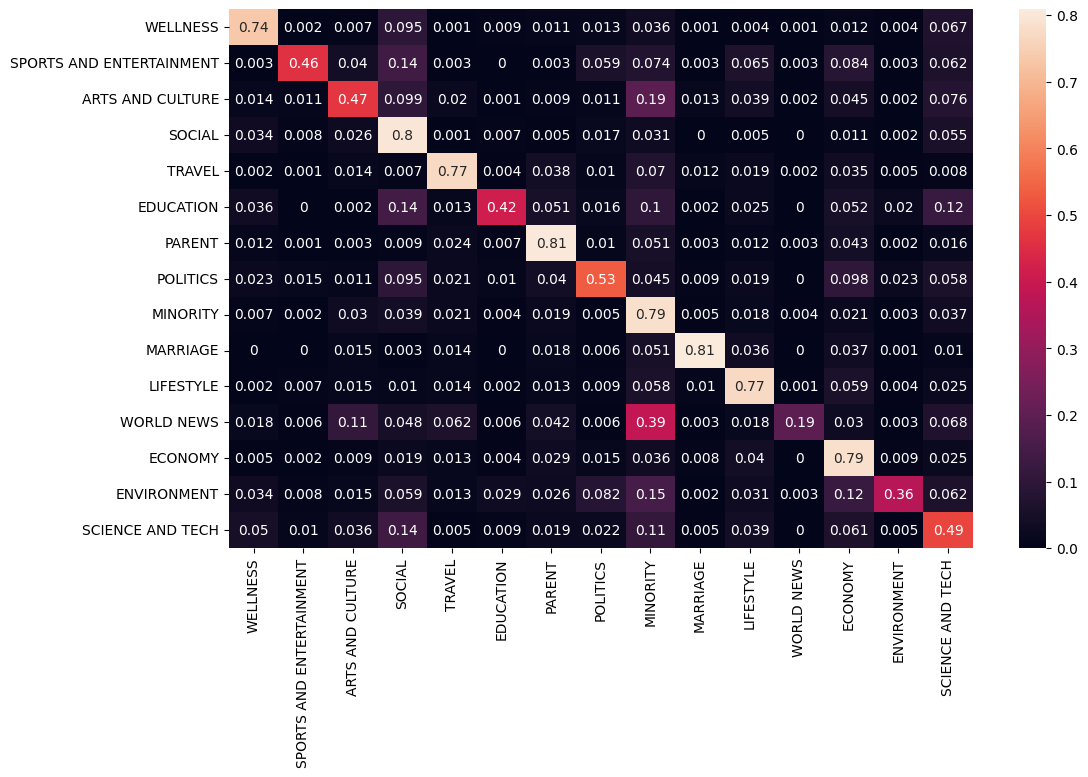

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
classes = processed_df['category'].unique()
cf_matrix = confusion_matrix(true_labels_name_cnn, predicted_labels_name_cnn, labels=classes)

# Normalize the confusion matrix
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], 
                     index=classes,
                     columns=classes).round(decimals=3)

# Plot the confusion matrix
plt.figure(figsize=(12, 7))
sns.heatmap(df_cm, annot=True)
plt.savefig("confusion_matrix_hitmap_fasttext.png")

### BERT Model

In [ ]:
from txtclassifier_bert import *

BERT_CASE = 'bert-base-uncased'
#BERT_CASE = 'bert-base-cased'

DROPOUT_RATE = 0.3
EPOCHS = 3
LR = 1e-6  

labels, decodes = label_importer("../data/label.json", "../data/label_decode.json")
tokenizer = BertTokenizer.from_pretrained(BERT_CASE)
model = BertClassifier(bert_case=BERT_CASE, dropout=DROPOUT_RATE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.load_state_dict(torch.load("../data/bert/bert_trained_2.pth", map_location=torch.device('cpu')))

# CAUTION this function takes upto 3 hours to run
y_true, y_pred, classes = evaluate(model, df_test, tokenizer, labels, decodes) 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15469/15469 [3:05:17<00:00,  1.39it/s]


                          precision    recall  f1-score   support

                POLITICS      0.800     0.828     0.814      5340
SPORTS AND ENTERTAINMENT      0.752     0.772     0.762      4818
                WELLNESS      0.766     0.844     0.804      3638
                  TRAVEL      0.863     0.852     0.857      2763
               LIFESTYLE      0.856     0.838     0.847      2474
                MINORITY      0.621     0.561     0.590      2355
                  SOCIAL      0.579     0.515     0.545      2084
                  PARENT      0.751     0.783     0.767      1905
              WORLD NEWS      0.766     0.740     0.753      1491
                 ECONOMY      0.668     0.586     0.624      1191
                MARRIAGE      0.814     0.868     0.840       998
        SCIENCE AND TECH      0.606     0.509     0.553       611
             ENVIRONMENT      0.537     0.661     0.593       610
        ARTS AND CULTURE      0.538     0.360     0.431       336
         

In [ ]:
print(classification_report(y_true, y_pred))

                          precision    recall  f1-score   support

        ARTS AND CULTURE       0.54      0.36      0.43       336
                 ECONOMY       0.67      0.59      0.62      1191
               EDUCATION       0.60      0.55      0.58       323
             ENVIRONMENT       0.54      0.66      0.59       610
               LIFESTYLE       0.86      0.84      0.85      2474
                MARRIAGE       0.81      0.87      0.84       998
                MINORITY       0.62      0.56      0.59      2355
                  PARENT       0.75      0.78      0.77      1905
                POLITICS       0.80      0.83      0.81      5340
        SCIENCE AND TECH       0.61      0.51      0.55       611
                  SOCIAL       0.58      0.52      0.55      2084
SPORTS AND ENTERTAINMENT       0.75      0.77      0.76      4818
                  TRAVEL       0.86      0.85      0.86      2763
                WELLNESS       0.77      0.84      0.80      3638
         

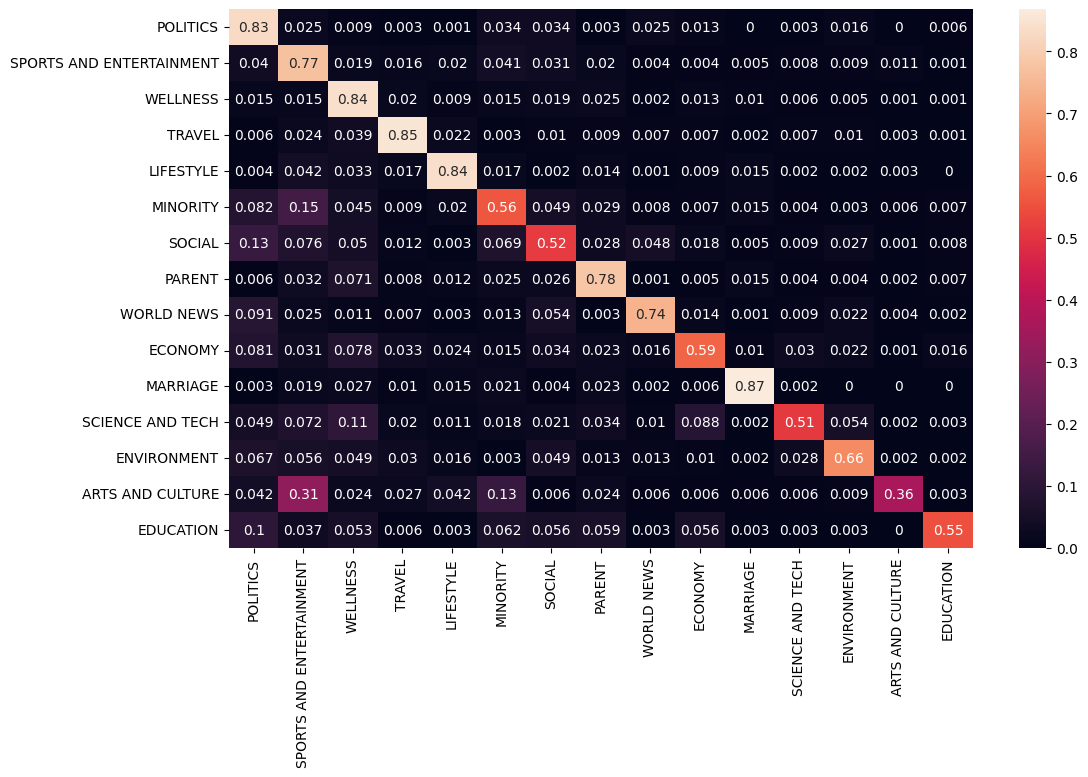

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred, labels=classes)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], 
                     index = classes,
                     columns = classes).round(decimals=3)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig("confusion_matrix_hitmap_bert.png")